使用的数据集：Fashion-MNIST
该数据集是MNIST（手写图片）的替代，内容是28px * 28px 的灰度图片，内容包括：上衣、裤子、鞋子等。
|标签|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-| 
|描述|T恤/上衣|裤子|套衫|裙子|外套|凉鞋|衬衫|运动鞋|包|踝靴|

In [10]:
# 下载数据集
import torchvision
import torchvision.transforms as transforms
data_dir = './data'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, transform=transform, download=True)

1. 制作批次数据集

In [11]:
import torch
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

2. 读取批次数据集

样本形状： torch.Size([10, 1, 28, 28])
样本标签： tensor([5, 9, 9, 4, 7, 0, 0, 5, 8, 5])
图片形状： torch.Size([3, 32, 302])
Sandal,Ankle_Book,Ankle_Book, Coat,Sneaker,T-shirt,T-shirt,Sandal,  Bag,Sandal


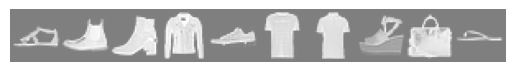

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):    # 定义显示图片函数
    print("图片形状：", np.shape(img))
    img = img / 2 + .5
    nping = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(nping, (1,2,0)))

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
'Sneaker', 'Bag', 'Ankle_Book')     # 定义类别名称
sample = iter(train_loader)         # 将数据集转化为迭代器
images, labels = sample.next()      # 从迭代器中去除一批次样本
print('样本形状：', np.shape(images))   # 打印样本的形状
print('样本标签：', labels)             
imshow(torchvision.utils.make_grid(images, nrow=batch_size))    # 数据可视化
print(','.join('%5s' % classes[labels[j]] for j in range(len(images))))

3. 定义模型类

In [13]:
import torch.nn.functional as F
class myConNet(torch.nn.Module):
    def __init__(self) -> None:
        super(myConNet, self).__init__()
        # 定义卷积层
        self.conv1=torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2=torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        # 定义全连接层
        self.fc1=torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2=torch.nn.Linear(in_features=120, out_features=60)
        self.out=torch.nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):   # 搭建正向结构
        # 第一层卷积层和池化层
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # 第二层卷积和池化处理
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # 搭建全连接网络，第一层全连接
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        # 第二层全连接
        t = self.fc2(t)
        t = F.relu(t)
        # 第三层全连接
        t = self.out(t)
        return t

In [25]:
network = myConNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
network.to(device)
print(network)
# 训练模型
device_count = torch.cuda.device_count() # 获取本机GPU显卡个数
print("cuda_device_count", device_count)
device_ids = list(range(device_count))  # 生成显卡索引列表
network = torch.nn.DataParallel(network, device_ids=device_ids)

cuda:0
myConNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
cuda_device_count 1


4. 定义损失的计算方法及优化器

In [15]:
criterion = torch.nn.CrossEntropyLoss() # 实例化损失函数类
optimizer = torch.optim.Adam(network.parameters(), lr=.01)

5. 训练模型

In [8]:
for epoch in range(2): # 训练模型
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0): # 循环取出批次数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()   # 清空之前的梯度
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # 反向传播
        optimizer.step() # 更新参数

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' % 
            (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0
print('Finish training')

[1,  1000] loss: 0.429
[1,  2000] loss: 0.315
[1,  3000] loss: 0.300
[1,  4000] loss: 0.281
[1,  5000] loss: 0.278
[1,  6000] loss: 0.281
[2,  1000] loss: 0.268
[2,  2000] loss: 0.268
[2,  3000] loss: 0.290
[2,  4000] loss: 0.264
[2,  5000] loss: 0.265
[2,  6000] loss: 0.274
Finish training


6. 保存模型

In [19]:
torch.save(network.state_dict(), 'models/CNNFashionMNIST.pth')

7. 加载模型，并对其进行预测

图片形状： torch.Size([3, 32, 302])
真实标签： Trouser Pullover Sneaker Trouser   Bag  Coat Shirt Sneaker Sneaker Dress
预测结果： Dress Pullover Sneaker Trouser   Bag Shirt Shirt Sneaker Sneaker Dress


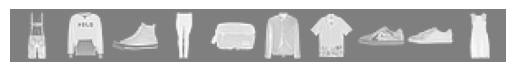

In [20]:
network.load_state_dict(torch.load('models/CNNFashionMNIST.pth'))   # 加载模型
dataiter = iter(test_loader)    # 获取测试数据
images, labels = dataiter.next()    
inputs, labels = images.to(device), labels.to(device)

imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print('真实标签：', 
' '.join('%5s' % classes[labels[j]] for j in range(len(images))))
outputs = network(inputs)   # 调用模型进行预测
_, predicted = torch.max(outputs, 1)  #计算分类结果
print('预测结果：', ' '.join('%5s' % classes[predicted[j]]
for j in range(len(images))))

8. 评估模型

In [23]:
# 测试模型
class_correct = list(0. for i in range(10)) # 定义列表，收集每个类的正确个数
class_total = list(0. for i in range(10))   # 定义列表，收集每个类的总个数
with torch.no_grad():
    for data in test_loader:    # 遍历测试数据集
        images, labels = data
        inputs, labels = images.to(device), labels.to(device)
        outputs = network(inputs)           # 将每批次的数据输入模型
        _, predicted = torch.max(outputs, 1)    # 计算预测结果
        predicted = predicted.to(device)
        c = (predicted == labels).squeeze()     # 统计正确个数
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item() # 如果该类标签预测正确，那么+1
            class_total[label] += 1             # 根据标签中的类别，计算类的总和
sumacc = 0
for i in range(10):
    Accuracy = 100 * class_correct[i] /class_total[i]   # 输出每个类的预测结果
    print('Accuracy of %5s : %2d %%' % (classes[i], Accuracy))
    sumacc = sumacc+Accuracy
print('Accuracy of all : %2d %%' % (sumacc/10 ))    # 输出最终的准确率

Accuracy of T-shirt : 81 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 80 %
Accuracy of Dress : 78 %
Accuracy of  Coat : 57 %
Accuracy of Sandal : 93 %
Accuracy of Shirt : 48 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 93 %
Accuracy of Ankle_Book : 92 %
Accuracy of all : 81 %
